# Installing required libraries

In [3]:
!pip install xgboost catboost polars optuna shap -q

In [4]:
!pip install scikit-learn-intelex -q

In [5]:
!pip install mlflow -q

# Importing required libraries

In [6]:
import pandas as pd
import polars as pl
import optuna
import pickle

import joblib

import numpy as np
## Enabling intel optimizations to 
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [7]:
import mlflow

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score, roc_auc_score, accuracy_score

In [9]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


# Helper functions

In [10]:
# Helper functions
def diag_med_lab_pid_exist_check(modeling_pids, diag_pid, medications_pid, lab_pid,age_data = None):
    # Convert sets of pids for faster lookup
    diag_pid_set = set(diag_pid)
    medications_pid_set = set(medications_pid)
    lab_pid_set = set(lab_pid)

    # Create the result list using a single loop
    if age_data:
        result = [
        f"{age}_{int(pid in diag_pid_set)}{int(pid in medications_pid_set)}{int(pid in lab_pid_set)}"
        for pid,age in zip(modeling_pids,age_data)
    ]
    else:
        result = [
            f"{int(pid in diag_pid_set)}{int(pid in medications_pid_set)}{int(pid in lab_pid_set)}"
            for pid in modeling_pids
        ]
    
    return result

In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, average_precision_score

def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    print("AUC:", roc_auc)

    # Calculate the Precision-Recall AUC
    auc_pr = average_precision_score(y_test, y_pred_proba[:, 1])
    print("Precision-Recall AUC:", auc_pr)

    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate Sensitivity and Specificity
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # handle division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # handle division by zero

    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    
    return cm, accuracy, roc_auc, auc_pr, sensitivity, specificity, report

# Config class

In [12]:
mlflow.set_tracking_uri("../Determine_ML_FLOW_Experiment")

In [254]:
class ml_config:
    base_folder ='../Determine_final_modeling_datasets/'
    columns_to_ignore_cat = ['PATIENT_NUM','FirstOutcomeDate','Outcome']
    target_column = 'Outcome'
    file = 'Determine_joined_med_usage_lab_median_domain_expert_diag_phemap_without_icd10z_bmi_bp_cvs_ordinal_nominal_encoded.parquet'
    
    patient_enc_info_path = '../Determine_cohort_after_visit_index_details.parquet'
    no_enc_ppid_experiment =  True
    low_feature_count_exclude = False
    
    pat_outcome0_with_dia_meds_remove = False
    
    sdoh_screening_experiment = True
    
    
    mlflow_experiment_name = 'Test101_mlflow'
    
    model_name = 'catboost'
    
    

# Loading modeling data file

In [255]:
modeling_df = pl.read_parquet(ml_config.base_folder + ml_config.file)

In [256]:
print("Number of data points in the dataset: ",len(modeling_df))

Number of data points in the dataset:  761594


In [257]:
modeling_df.filter(pl.col('Outcome')==1).sort('FirstOutcomeDate', descending=False).head()

PATIENT_NUM,Age_group,FirstOutcomeDate,Outcome,phenazopyridine,nitrofurantoin,lisinopril_hydrochlorothiazide,amlodipine,cephalexin,albuterol,nystatin,metronidazole,mometasone_formoterol,varicella-zoster virus vaccine live (Oka-Merck) strain,potassium chloride,chlorthalidone,ketorolac,azithromycin,triamcinolone,gabapentin,acetaminophen_hydrocodone,capsaicin,naproxen,tramadol,ibuprofen,codeine_promethazine,omeprazole,clotrimazole,lorazepam,fluticasone,calcium carbonate,loratadine,paroxetine,cholecalciferol,aluminum chloride,penicillin G,sulfamethoxazole_trimethoprim,…,LOINC:2148-5,LOINC:38252-3,LOINC:72888-1,LOINC:83102-4,LOINC:38506-2,LOINC:26499-4,LOINC:2609-6,LOINC:2579-1,LOINC:26019-0,LOINC:33951-5,LOINC:26498-6,LOINC:2669-0,LOINC:30433-7,LOINC:42246-9,mode_height,median_weight,BMI,median_diastolic_value,median_systolic_value,ACS_MedHHIncome,ACS_GINI,ACS_Unemployment,ACS_pctPoverty100,ACS_pctCollGrad,Sex_CD_F,Sex_CD_M,Race_CD_01,Race_CD_02,Race_CD_03,Race_CD_04,Race_CD_05,Hispanic_CD_N,Hispanic_CD_Y,Gender_CD_GQ,Gender_CD_M,Gender_CD_TG,Gender_CD_W
i64,i64,datetime[μs],i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f32,f32,f32,f32,f32,f32,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
8905893,3,2016-04-05 00:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0,1,0,0,0,0,0,0,1,0,1,0,0
10799365,2,2016-04-08 00:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0,1,0,0,0,0,1,0,1,0,0,0,0
6601492,4,2016-04-19 00:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,1,0,0,0,0,0,1,1,0,0,0,0,0
5674597,1,2016-04-20 00:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,1,0,0,0,1,0,0,1,0,0,0,0,0
11624705,1,2016-04-22 00:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,1,0,0,0,0,0,1,0,1,0,0,0,1


In [258]:
modeling_df.filter(pl.col('PATIENT_NUM') == 297249)

PATIENT_NUM,Age_group,FirstOutcomeDate,Outcome,phenazopyridine,nitrofurantoin,lisinopril_hydrochlorothiazide,amlodipine,cephalexin,albuterol,nystatin,metronidazole,mometasone_formoterol,varicella-zoster virus vaccine live (Oka-Merck) strain,potassium chloride,chlorthalidone,ketorolac,azithromycin,triamcinolone,gabapentin,acetaminophen_hydrocodone,capsaicin,naproxen,tramadol,ibuprofen,codeine_promethazine,omeprazole,clotrimazole,lorazepam,fluticasone,calcium carbonate,loratadine,paroxetine,cholecalciferol,aluminum chloride,penicillin G,sulfamethoxazole_trimethoprim,…,LOINC:2148-5,LOINC:38252-3,LOINC:72888-1,LOINC:83102-4,LOINC:38506-2,LOINC:26499-4,LOINC:2609-6,LOINC:2579-1,LOINC:26019-0,LOINC:33951-5,LOINC:26498-6,LOINC:2669-0,LOINC:30433-7,LOINC:42246-9,mode_height,median_weight,BMI,median_diastolic_value,median_systolic_value,ACS_MedHHIncome,ACS_GINI,ACS_Unemployment,ACS_pctPoverty100,ACS_pctCollGrad,Sex_CD_F,Sex_CD_M,Race_CD_01,Race_CD_02,Race_CD_03,Race_CD_04,Race_CD_05,Hispanic_CD_N,Hispanic_CD_Y,Gender_CD_GQ,Gender_CD_M,Gender_CD_TG,Gender_CD_W
i64,i64,datetime[μs],i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f32,f32,f32,f32,f32,f32,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
297249,0,2017-05-23 00:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,72.0,312.350006,42.357648,96.502357,128.833328,-100.0,-100.0,-100.0,-100.0,-100.0,1,0,0,0,1,0,0,1,0,0,0,0,1


In [223]:
np.unique(modeling_df['Outcome'].to_list(),return_counts = True)

(array([0, 1]), array([42123,  1501]))

In [224]:
if ml_config.no_enc_ppid_experiment:
    modeling_patient_ids = modeling_df['PATIENT_NUM'].to_list()
    pids_enc_info_after_vi = pl.read_parquet(ml_config.patient_enc_info_path)['PATIENT_NUM'].to_list()
    pids_to_drop = set(modeling_patient_ids) - set(pids_enc_info_after_vi)
    modeling_df = modeling_df.filter(((~pl.col('PATIENT_NUM').is_in(pids_to_drop)) & (pl.col('Outcome')==0)) | (pl.col('Outcome')==1))
    print("Number of records after dropping the patients who dont have encounters after their index visit:",len(modeling_df))
    print("The target distribution is:", np.unique(modeling_df['Outcome'].to_list(),return_counts = True) )

Number of records after dropping the patients who dont have encounters after their index visit: 43624
The target distribution is: (array([0, 1]), array([42123,  1501]))


In [225]:
# if ml_config.low_feature_count_exclude:
    
    
if ml_config.pat_outcome0_with_dia_meds_remove:
    with open('Determine_outcome0_act_ing_dia_after_index_visit_patient_nums.pkl', 'rb') as f:
        pat_outcome0_with_dia_meds_remove = pickle.load(f)
        
    modeling_df = modeling_df.filter(((~pl.col('PATIENT_NUM').is_in(pids_to_drop)) & (pl.col('Outcome')==0)) | (pl.col('Outcome')==1)) 

In [226]:
# modeling_df  = modeling_df.drop(ml_config.columns_to_drop)
# modeling_df.head()

In [227]:
### Defining categorical columns
cat_features = [col for col in modeling_df.columns if  not (col.startswith('LOINC') 
                                                            or col in ml_config.columns_to_ignore_cat
                                                            or col in ['BMI',
                                                                       'mode_height',
                                                                       'average_weight',
                                                                         'average_diastolic_value',
                                                                         'average_systolic_value',
                                                                          "ACS_MedHHIncome", 
                                                                       "ACS_GINI", 
                                                                       "ACS_Unemployment", 
                                                                       "ACS_pctPoverty100", 
                                                                       "ACS_pctCollGrad"]
                                                                          )]
numerical_features = [col for col in modeling_df.columns if col.startswith('LOINC') 
                                                            or col not in ml_config.columns_to_ignore_cat
                                                            or col in ['BMI',
                                                                       'mode_height',
                                                                       'average_weight',
                                                                         'average_diastolic_value',
                                                                         'average_systolic_value',
                                                                          "ACS_MedHHIncome", 
                                                                       "ACS_GINI", 
                                                                       "ACS_Unemployment", 
                                                                       "ACS_pctPoverty100", 
                                                                       "ACS_pctCollGrad"]
                                                                          ] + [
                                                                            "mode_height",
                                                                            "median_value",
                                                                            "slope_weight",
                                                                            "BMI",
                                                                            "median_diastolic_value",
                                                                            "slope_dia_bp",
                                                                            "median_systolic_value",
                                                                            "slope_sys_bp"
                                                                        ]

In [228]:
'average_weight' in cat_features

False

In [229]:
print("Number of categorical features: ",len(cat_features))
print("Number of numerical features: ",len(numerical_features))

Number of categorical features:  2416
Number of numerical features:  2904


In [230]:
loinc_columns = [col for col in modeling_df.columns if col.startswith('LOINC')]
print("Number of lab results features: ",len(loinc_columns))

Number of lab results features:  473


In [231]:
### VERY IMPORTANT!!!!
modeling_df = modeling_df.with_columns([
    pl.col(col).cast(pl.Float32)
    for col in loinc_columns
])

In [232]:
modeling_df.head()

PATIENT_NUM,Age_group,FirstOutcomeDate,Outcome,phenazopyridine,nitrofurantoin,lisinopril_hydrochlorothiazide,amlodipine,cephalexin,albuterol,nystatin,metronidazole,mometasone_formoterol,varicella-zoster virus vaccine live (Oka-Merck) strain,potassium chloride,chlorthalidone,ketorolac,azithromycin,triamcinolone,gabapentin,acetaminophen_hydrocodone,capsaicin,naproxen,tramadol,ibuprofen,codeine_promethazine,omeprazole,clotrimazole,lorazepam,fluticasone,calcium carbonate,loratadine,paroxetine,cholecalciferol,aluminum chloride,penicillin G,sulfamethoxazole_trimethoprim,…,SDH:ADV0111 _0.0,SDH:ADV0111 _1.0,SDH:ADV0113 _0.0,SDH:ADV0113 _1.0,SDH:ADV0104 _0.0,SDH:ADV0104 _1.0,SDH:ADV0261 _0.0,SDH:ADV0261 _1.0,SDH:ADV0114 _0.0,SDH:ADV0114 _1.0,SDH:ADV0115 _0.0,SDH:ADV0115 _1.0,SDH:ADV0116 _0.0,SDH:ADV0116 _1.0,SDH:ADV0117 _0.0,SDH:ADV0117 _1.0,SDH:ADV0118 _0.0,SDH:ADV0118 _1.0,SDH:ADV0262 _0.0,SDH:ADV0262 _1.0,SDH:ADV0400 _0.0,SDH:ADV0400 _1.0,SDH:ADV0401 _0.0,SDH:ADV0401 _1.0,Sex_CD_F,Sex_CD_M,Race_CD_01,Race_CD_02,Race_CD_03,Race_CD_04,Race_CD_05,Hispanic_CD_N,Hispanic_CD_Y,Gender_CD_GQ,Gender_CD_M,Gender_CD_TG,Gender_CD_W
i64,i64,datetime[μs],i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
576517,2,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
5886210,3,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,…,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
390161,0,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
5378498,3,null,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,…,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3476481,3,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


# Train/test split

In [233]:
data_train_pids, data_test_pids = train_test_split(modeling_df['PATIENT_NUM'], test_size=0.2, stratify=modeling_df['Outcome'], random_state = 42)

In [234]:
data_train_pids = data_train_pids.to_list()
data_test_pids = data_test_pids.to_list()

In [235]:
len(data_test_pids)

8725

In [236]:
if ml_config.sdoh_screening_experiment:

    with open('sdohscreen-test_data_pids.pkl', 'wb') as file: 
        # A new file will be created 
        pickle.dump(data_test_pids, file) 

    with open('sdohscreen-train_data_pids.pkl', 'wb') as file: 
        # A new file will be created 
        pickle.dump(data_train_pids, file) 

    #Open the file in binary mode 
    with open('sdohscreen-train_data_pids.pkl', 'rb') as file: 
        train_pids = pickle.load(file) 
    with open('sdohscreen-test_data_pids.pkl', 'rb') as file: 
        test_pids = pickle.load(file)  
    
    
else:
    # saving test pids
    # with open('test_data_pids.pkl', 'wb') as file: 
    #     # A new file will be created 
    #     pickle.dump(data_test_pids, file) 

    # with open('train_data_pids.pkl', 'wb') as file: 
    #     # A new file will be created 
    #     pickle.dump(data_train_pids, file) 

    #Open the file in binary mode 
    with open('train_data_pids.pkl', 'rb') as file: 
        train_pids = pickle.load(file) 
    with open('test_data_pids.pkl', 'rb') as file: 
        test_pids = pickle.load(file) 
    
print("Number of train pids: ", len(train_pids))
print("Number of test pids: ", len(test_pids))

Number of train pids:  34899
Number of test pids:  8725


In [237]:
train_pids = list(set(data_train_pids+data_test_pids) - set(test_pids))

In [238]:
data_train = modeling_df.filter(pl.col('PATIENT_NUM').is_in(train_pids))
data_test = modeling_df.filter(pl.col('PATIENT_NUM').is_in(test_pids))

In [239]:
print(len(data_train))
print(len(data_test))

34899
8725


In [240]:
np.unique(data_test['Outcome'].to_list(), return_counts =True)

(array([0, 1]), array([8425,  300]))

In [241]:
del modeling_df

In [242]:
test_data_firstoutcome_df = data_test.select(['PATIENT_NUM','FirstOutcomeDate','Outcome'])

In [243]:
X_train,y_train = data_train.drop(['PATIENT_NUM','FirstOutcomeDate','Outcome']).to_pandas(), data_train['Outcome'].to_pandas()
X_test,y_test = data_test.drop(['PATIENT_NUM','FirstOutcomeDate','Outcome']).to_pandas(), data_test['Outcome'].to_pandas()

In [244]:
type(y_train)

pandas.core.series.Series

In [204]:
# del data_train#, data_test

### Adjusting features based on model_name (some models need feature scaling for numerical data)

In [122]:
from sklearn.preprocessing import StandardScaler

In [123]:
# Initialize the scaler

if ml_config.model_name == 'logistic_regression':
    scaler = StandardScaler()

    # Fit and transform only the specified columns
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Boruta feature selection

In [124]:
!pip install boruta -q 

In [ ]:
loinc_columns = [col for col in X_train.columns if col.startswith('LOINC')]
len(loinc_columns)

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs =-1)

In [ ]:
nan_columns = X_train.columns[X_train.isna().any()].tolist()

print(nan_columns)

In [ ]:
print("hello")

In [ ]:
trans = BorutaPy(clf, max_iter=5, random_state=42)
sel = trans.fit_transform(X_train.values, y_train.values)

In [ ]:
print('Hello')

# ML models

## Single objective function

In [249]:
# Remove columns starting with 'SDH'
X_train = X_train.loc[:, ~X_train.columns.str.startswith('SDH')]
X_test = X_test.loc[:, ~X_test.columns.str.startswith('SDH')]

In [211]:
def objective(trial):
    if ml_config.model_name == 'xgboost':
    
        param = {
        'objective': 'binary:logistic',  # Binary classification
        #'eval_metric': 'auc',             # Evaluation metric
        'seed': 42,
        'eta': trial.suggest_float('eta', 0.01, 0.3, step=0.01),
        'n_estimators': trial.suggest_int('n_estimators', 100, 600, step =100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'scale_pos_weight': (len(y_train) - sum(y_train)) / sum(y_train),  # Class weight for imbalance
        }
        
        model = XGBClassifier(**param, enable_categorical=True, device="cuda")

    elif ml_config.model_name == 'catboost':
        param = {
            "iterations": trial.suggest_categorical('iterations',[200, 400, 600, 800]),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "depth": trial.suggest_int("depth", 4, 12),
            #"subsample": trial.suggest_float("subsample", 0.05, 1.0),
            #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
            'task_type':"GPU",
        }
        model = CatBoostClassifier(**param, auto_class_weights='Balanced',allow_writing_files=False,
                                   silent=True)

    elif ml_config.model_name == 'random_forest':
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 800),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestClassifier(**param, class_weight ='balanced', n_jobs = -1)

    elif ml_config.model_name == 'logistic_regression':
        param = {
            'C': trial.suggest_loguniform('C', 1e-2, 10.0),
            'max_iter': trial.suggest_int('max_iter', 100, 600),
            'solver': trial.suggest_categorical('solver', ['liblinear']),
        }
        model = LogisticRegression(**param,class_weight ='balanced', n_jobs = -1 )
        
    
    

    else:
        raise ValueError("Unsupported model name")
    
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
        
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc


In [212]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= 5)

print('')
print('Best hyperparameters:', study.best_params)
print('Best AUC:', study.best_value)
print('')

[I 2025-04-30 21:31:14,069] A new study created in memory with name: no-name-130f73df-fe71-4d9d-88af-8f4c796ebd90
[W 2025-04-30 21:31:20,664] Trial 0 failed with parameters: {'iterations': 800, 'learning_rate': 0.038778657582876845, 'depth': 6, 'min_data_in_leaf': 245} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_28807/1042716350.py", line 56, in objective
    model.fit(X_train, y_train)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/catboost/core.py", 

KeyboardInterrupt: 

In [250]:
# best_params =study.best_params

if ml_config.model_name == 'xgboost':
        
    model = XGBClassifier(**best_params, 
                          scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train),  
#                           use_label_encoder=False,
                          device = 'cuda', 
                          )
    
elif ml_config.model_name == 'catboost':
    model = CatBoostClassifier(#**best_params, 
                               auto_class_weights='Balanced',allow_writing_files=False,
                                   task_type ='GPU',
                                   silent=True)
    
elif ml_config.model_name == 'random_forest':
    model = RandomForestClassifier(**best_params, class_weight ='balanced', n_jobs = -1)
    
elif ml_config.model_name == 'logistic_regression':
    model = LogisticRegression(**best_params, class_weight ='balanced', n_jobs = -1)
    
else:
    raise ValueError("Unsupported model name")

In [251]:
model.fit(X_train,y_train)

In [252]:
conf_matrix, accuracy, roc_auc, sensitivity, specificity, auc_pr, cr = get_metrics(model,X_test, y_test)

Accuracy: 0.7462464183381089
AUC: 0.7821467853610287
Precision-Recall AUC: 0.1214866142675135
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85      8425
           1       0.08      0.65      0.15       300

    accuracy                           0.75      8725
   macro avg       0.53      0.70      0.50      8725
weighted avg       0.95      0.75      0.83      8725

Sensitivity (Recall): 0.6533333333333333
Specificity: 0.7495548961424332


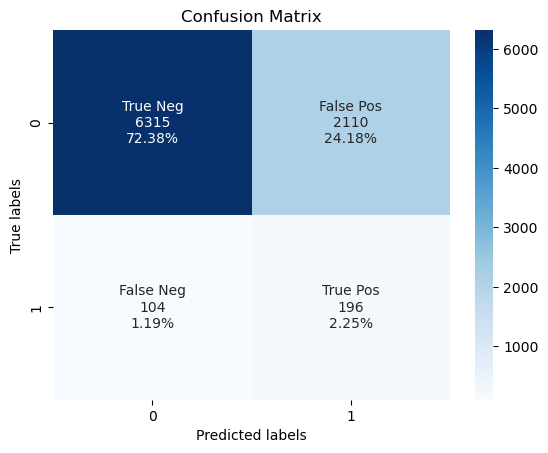

In [253]:
## Confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
cm_plot = plt.subplot()
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

#Labels, title and ticks
cm_plot.set_xlabel('Predicted labels');cm_plot.set_ylabel('True labels');
cm_plot.set_title('Confusion Matrix'); 
plt.show()

In [ ]:
# Save model using joblib
model_filename = f"../Determine_trained_models/{ml_config.model_name}_dataset_{ml_config.file.split('.')[0]}.pkl"
joblib.dump(model, model_filename)

print(f"Model saved as {model_filename}")

## Saving results and details to ml flow

In [ ]:
params = model.get_params()


# Create a new MLflow Experiment
mlflow.set_experiment(f"{ml_cofig.mlflow_experiment_name}_ModelName_{ml_config.model_name}",
                     description=ml_config.description)

# Start an MLflow run
with mlflow.start_run():
    
    #set tags
    tags = {
        'model_name': ml_config.model_name
        'dataset_filename':ml_config.file
    }
    
    # Log train and test PIDs
    mlflow.log_param("train_pid", train_pid)
    mlflow.log_param("test_pid", test_pid)
    
    # Log the hyperparameters   
    mlflow.log_params(params)
    
    mlflow.log_input(X_train, context="training")
    mlflow.log_input(X_test, context="testing")

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("sensitivity", sensitivity)
    mlflow.log_metric("specificity", sensitivity)
    mlflow.log_metric("auc_pr", accuracy)
    mlflow.log_dict(cr, "classification_report.json")
    
    mlflow.log_image(cm_plot, "confusion_matrix.png")



## Individual experiments

In [ ]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(model, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)

# Plot the summary
shap.summary_plot(shap_values, X_test, max_display=5)

In [ ]:
# Calculate SHAP values
shap_values = explainer(X_test)

# Plot the summary
shap.summary_plot(shap_values, X_test)

### Experiment: Understanding how low feature count features are classified

In [ ]:
with open('../Experiment related files/pids_1_feat_bmi_missing.pkl','rb') as f:
    pids_1_feat_bmi_missing = pickle.load(f).to_list()
print("Number of patient IDs:", len(pids_1_feat_bmi_missing))

In [ ]:
pids_1_feat_bmi_missing[:5]

In [ ]:
data_test_with_index = data_test.with_row_index("row_nr", offset=1) 
data_test_with_index.filter(pl.col('PATIENT_NUM').is_in(pids_1_feat_bmi_missing))

In [ ]:
data_test.filter(pl.col('PATIENT_NUM') == 2386950).index

In [ ]:
shap.plots.waterfall(shap_values[9], max_display=50)

#### Hypothesis: removing data points which have feature count 1, bmi and bp missing, will improve perofrmance of test_dataset

In [ ]:
data_train.filter(pl.col('PATIENT_NUM').is_in(pids_1_feat_bmi_missing))

In [ ]:
print("Data train before removing pids:",len(data_train))

In [ ]:
data_train = data_train.filter(~pl.col('PATIENT_NUM').is_in(pids_1_feat_bmi_missing))
# data_test = data_test.filter(~pl.col('PATIENT_NUM').is_in(pids_1_feat_bmi_missing))

In [ ]:
print("Data train after removing pids:",len(data_train))

In [ ]:
X_train,y_train = data_train.drop(['PATIENT_NUM','FirstOutcomeDate','Outcome']).to_pandas(), data_train['Outcome'].to_pandas()
X_test,y_test = data_test.drop(['PATIENT_NUM','FirstOutcomeDate','Outcome']).to_pandas(), data_test['Outcome'].to_pandas()

In [ ]:
model = CatBoostClassifier( auto_class_weights='Balanced',allow_writing_files=False,
                                   task_type ='GPU',
                                   silent=True)

In [ ]:
model.fit(X_train,y_train)

In [ ]:
## Metrics
conf_matrix, accuracy, roc_auc, sensitivity, specificity, auc_pr, cm = get_metrics(model,X_test, y_test)

## TP, TN, FN and FP indexes

In [ ]:
# model  = CatBoostClassifier().load_model('../Determine_trained_models/Catboost'+ ml_config.file)

In [ ]:
# Assuming 'model' is your trained model and it has a predict method
# Predict on the train data
predictions = model.predict(X_test)

# Boolean array where True indicates false positives
false_positives_mask = (predictions == 1) & (y_test == 0)
false_negatives_mask = (predictions == 0) & (y_test == 1)
true_positives_mask = (predictions == 1) & (y_test == 1)
true_negatives_mask = (predictions == 0) & (y_test == 0)
# Get indices of false positives
false_positive_indices = np.where(false_positives_mask)[0]
false_negatives_indices = np.where(false_negatives_mask)[0]
true_positives_indices = np.where(true_positives_mask)[0]
true_negatives_indices = np.where(true_negatives_mask)[0]

print("Indices of False Positives:", false_positive_indices)
print("Indices of False Negatives:", false_negatives_indices)
print("Indices of True Positives:", true_positives_indices)
print("Indices of True Negatives:", true_negatives_indices)

In [ ]:
len(false_positive_indices)

In [ ]:
len(false_negatives_indices)

In [ ]:
data_test_pids_fp = data_test[false_positive_indices]['PATIENT_NUM'].to_list()
data_test_pids_fn = data_test[false_negatives_indices]['PATIENT_NUM'].to_list()
data_test_pids_tp = data_test[true_positives_indices]['PATIENT_NUM'].to_list()
data_test_pids_tn = data_test[true_negatives_indices]['PATIENT_NUM'].to_list()


In [ ]:
directory_path = f"./FP_FN_{ml_config.file.split('.')[0]}"

# Create the directory
os.makedirs(directory_path, exist_ok=True)

In [ ]:
import pickle

labels = {
    'false_positives': data_test_pids_fp,
    'false_negatives': data_test_pids_fn,
    'true_positives': data_test_pids_tp,
    'true_negatives': data_test_pids_tn
}

# Save all
for label, data in labels.items():
    with open(f'./{directory_path}/{ml_config.model_name}_{label}_pids_test.pkl', 'wb') as file:
        pickle.dump(data, file)

# Load all
loaded = {}
for label in labels:
    with open(f'./{directory_path}/{ml_config.model_name}_{label}_pids_test.pkl', 'rb') as file:
        loaded[label] = pickle.load(file)

# Unpack if needed
data_test_pids_fp = loaded['false_positives']
data_test_pids_fn = loaded['false_negatives']
data_test_pids_tp = loaded['true_positives']
data_test_pids_tn = loaded['true_negatives']

In [ ]:
from datetime import datetime

In [ ]:
data_test.filter(pl.col('PATIENT_NUM').is_in(data_test_pids_fn)).sort('FirstOutcomeDate').filter(pl.col("FirstOutcomeDate") < datetime(2019, 1, 2))
          #,return_counts = True)

In [ ]:
data_test.filter(pl.col('PATIENT_NUM').is_in(data_test_pids_fp)).filter(pl.col("Outcome")== 1)
          #,return_counts = True)

In [ ]:
data_test[[36, 54]]

## Feature Importance using SHaP

In [ ]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)

# Plot the summary
shap.summary_plot(shap_values, X_test)

# Fairness metrics

# Sub-group performance

In [ ]:
## model to use
model  = CatBoostClassifier().load_model('../Determine_trained_models/catboost_whole_dataset_phecodes_bmi_bp')

In [ ]:
X_test.columns[:15]

In [ ]:
y_test.values

In [ ]:
def predict_on_data(sub_x_test,sub_y_test, model):
    y_pred = model.predict(sub_x_test)
    y_pred_probs = model.predict_proba(sub_x_test)[:,1]
    
    tn, fp, fn, tp = confusion_matrix(sub_y_test, y_pred).ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)
    roc_auc = roc_auc_score(sub_y_test, y_pred_probs)
    print("ROC curve: ", roc_auc)
    
    acc = accuracy_score(sub_y_test, y_pred)
    print('Accuracy: ', acc)
    return sensitivity, specificity, roc_auc, acc
    
     

In [ ]:
# - **'DEM|RACE:01'**: White
# - **'DEM|RACE:02'**: Black or African American
# - **'DEM|RACE:03'**: Asian
# - **'DEM|RACE:04'**: Native Hawaiian or Other Pacific Islander
# - **'DEM|RACE:05'**: American Indian or Alaska Native
# - **'DEM|RACE:06'**: Other or Unknown
# - **'DEM|RACE:07'**: More than one race

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
race_cols = [
    "Race_CD_01",
    "Race_CD_02",
    "Race_CD_03",
    "Race_CD_04",
    "Race_CD_05",
    "Race_CD_06",
    "Race_CD_07",
    "Race_CD_UNK"
]

races = []
sens = []
specs = []
roc_aucs = []
counts = []
races = []
class_1_count = []

for col in race_cols:
    if col.endswith('01'):
        race = 'white'
    if col.endswith('02'):
        race = 'Black or African American'
    if col.endswith('03'):
        race = 'Asian'
    if col.endswith('04'):
        race = 'Native Hawaiian or Other Pacific Islander'
    if col.endswith('05'):
        race = 'American Indian or Alaska Native'
    if col.endswith('06'):
        race = 'Multiple Race'
    if col.endswith('07'):
        race = 'refuse to Answer'
    elif col.endswith('UNK'):
        race = 'UNK'
        
    print("Number of data points with race {} are: {}".format( col, X_test[X_test[col]==1].shape[0] ))
    
    # Get indexes where the value is 1 for the current race column
    X_test_race = X_test[X_test[col] == 1]
    indexes = X_test_race.index
    
    # Retrieve the respective y_test data using these indexes
    y_test_race = y_test.loc[indexes]
    
    sensitivity, specificity, roc_auc = predict_on_data(X_test_race, y_test_race, model)
    races.append(race)
    sens.append(sensitivity)
    specs.append(specificity)
    roc_aucs.append(roc_auc)
    class_1_count.append(sum(y_test_race.values))
    counts.append(X_test[X_test[col]==1].shape[0])
    

    

In [ ]:
df = pd.DataFrame({
    'Race': races,
    'counts':counts,
    'class_1 count': class_1_count,
    'Sensitivity': sens,
    'Specificity': specs,
    'ROC_AUC': roc_aucs
})
df

In [ ]:
to_collapse = df.iloc[5:8]

# Calculate the new collapsed row
new_row = {
    'Race': 'Collapsed Race',
    'counts': to_collapse['counts'].sum(),
    'class_1 count': to_collapse['class_1 count'].sum(),
    'Sensitivity': to_collapse['Sensitivity'].mean(),
    'Specificity': to_collapse['Specificity'].mean(),
    'ROC_AUC': to_collapse['ROC_AUC'].mean()
}

# Drop the old rows and append the new row
df = df.drop(index=range(5, 8)).append(new_row, ignore_index=True)

In [ ]:
new_row

In [ ]:
age_groups = np.unique(X_test['Age_group'].values)

age_ranges = []
sens = []
specs = []
roc_aucs = []
counts =[]
class_1_count = []

races = []
for age_enc in age_groups:
    
    if age_enc == 0:
        age = '18-34'
    elif age_enc == 1:
        age = '35-44'
    elif age_enc == 2:
        age = '45-54'
    elif age_enc == 3:
        age = '54-65'
    elif age_enc == 4:
        age = '65-74'
    else:
        age = '75_older'
        
    print("Number of data points with age group {} are: {}".format( age_enc, X_test[X_test['Age_group']== age_enc].shape[0] ))
    
    # Get indexes where the value is 1 for the current race column
    X_test_race = X_test[X_test['Age_group']== age_enc]
    indexes = X_test_race.index
    
    # Retrieve the respective y_test data using these indexes
    y_test_race = y_test.loc[indexes]
    
    sensitivity, specificity, roc_auc = predict_on_data(X_test_race, y_test_race, model)
    age_ranges.append(age)
    sens.append(sensitivity)
    specs.append(specificity)
    roc_aucs.append(roc_auc)
    class_1_count.append(sum(y_test_race.values))
    counts.append(X_test[X_test['Age_group']== age_enc].shape[0])
    
#     # SHAP analysis for top features
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test_race)
    
#     # Compute mean absolute SHAP values for each feature
#     mean_shap_values = np.abs(shap_values).mean(axis=0)
    
#     # Get feature names
#     feature_names = X_test_race.columns
    
#     # Get and display top 5 features for the current age group
#     top_5_indices = np.argsort(mean_shap_values)[-5:][::-1]
#     top_5_features = [feature_names[i] for i in top_5_indices]
# #     top_features.append(top_5_features)
    
#     # Plotting top 5 features for the current age group
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=mean_shap_values[top_5_indices], y=[feature_names[i] for i in top_5_indices], palette="viridis")
#     plt.title(f"Top 5 Features for Age Group {age}: SHAP Importance")
#     plt.xlabel("Mean SHAP Value (absolute)")
#     plt.ylabel("Features")
#     plt.show()
    

In [ ]:
df = pd.DataFrame({
    'Age_Group': age_ranges,
    'counts': counts,
    'class_1 count': class_1_count,
    'Sensitivity': sens,
    'Specificity': specs,
    'ROC_AUC': roc_aucs,
})
df

## Gender

In [ ]:
gender_cols = ["Gender_CD_GQ", "Gender_CD_M", "Gender_CD_TG", "Gender_CD_UNK", "Gender_CD_W"]

In [ ]:
gender_list = []
sens = []
specs = []
roc_aucs = []
counts =[]
class_1_count = []

races = []
for gen in gender_cols:
    
    if gen.endswith('GQ'):
        gender = 'GenderQueer'
    elif gen.endswith('M'):
        gender = 'Man'
    elif gen.endswith('W'):
        gender = 'Woman'
    elif gen.endswith('TG'):
        gender = 'Transgender'
    elif gen.endswith('UNK'):
        gender = 'Unknown'

        
    print("Number of data points with gender group {} are: {}".format( gender, X_test[X_test[gen]== 1].shape[0] ))
    
    # Get indexes where the value is 1 for the current race column
    X_test_gen = X_test[X_test[gen]== 1]
    indexes = X_test_gen.index
    
    # Retrieve the respective y_test data using these indexes
    y_test_gen = y_test.loc[indexes]
    
    sensitivity, specificity, roc_auc,_ = predict_on_data(X_test_gen, y_test_gen, model)
    gender_list.append(gender)
    sens.append(sensitivity)
    specs.append(specificity)
    roc_aucs.append(roc_auc)
    class_1_count.append(sum(y_test_gen.values))
    counts.append(X_test[X_test[gen]== 1].shape[0])

In [ ]:
df = pd.DataFrame({
    'Gender': gender_list,
    'counts': counts,
    'class_1 count': class_1_count,
    'Sensitivity': sens,
    'Specificity': specs,
    'ROC_AUC': roc_aucs,
})
df.reset_index(drop=True, inplace=True)
df

# 5-year performance

In [ ]:
model  = CatBoostClassifier().load_model('../Determine_trained_models/catboost_whole_dataset_phecodes_bmi_bp')

In [ ]:
req_test_dates_df = test_data_firstoutcome_df.drop_nulls().to_pandas()
req_test_dates_df

In [ ]:
# Constants
start_date = pd.Timestamp('2019-04-01')

# Calculate the difference in years between the Index_Start_date and the start_date if data is available
req_test_dates_df['year_difference'] = (req_test_dates_df['FirstOutcomeDate'] - start_date).dt.days / 365.25

# Filter DataFrames based on year difference, ignore NaNs as they indicate missing data in cohort_df
df_less_than_1 = req_test_dates_df[req_test_dates_df['year_difference'] < 1].dropna()
df_1_to_2 = req_test_dates_df[(req_test_dates_df['year_difference'] >= 1) & (req_test_dates_df['year_difference'] < 2)].dropna()
df_2_to_3 = req_test_dates_df[(req_test_dates_df['year_difference'] >= 2) & (req_test_dates_df['year_difference'] < 3)].dropna()
df_3_to_4 = req_test_dates_df[(req_test_dates_df['year_difference'] >= 3) & (req_test_dates_df['year_difference'] < 4)].dropna()
df_4_to_5 = req_test_dates_df[(req_test_dates_df['year_difference'] >= 4) & (req_test_dates_df['year_difference'] < 5)].dropna()

In [ ]:
year_ranges = []
sens = []
specs = []
roc_aucs = []
counts =[]
class_1_count = []
acc_scores = []

In [ ]:
for i,buf_df in enumerate([df_less_than_1, df_1_to_2, df_2_to_3, df_3_to_4]):
     # Use the index of buf_df
    indices = buf_df.index
    # Use the index to filter X_test
    X_test_buf = X_test.loc[indices.intersection(X_test.index)]
    y_test_buf = y_test.loc[indices.intersection(X_test.index)]
    
    if i == 0:
        year ='Less than 1 year'
    if i == 1:
        year ='Between 1 and 2 year'
    if i == 2:
        year ='Between 2 and 3 year'
    if i == 3:
        year ='Between 3 and 4 year'
    
    print(year)
    sensitivity, specificity, roc_auc, acc = predict_on_data(X_test_buf, y_test_buf, model)
    year_ranges.append(year)
    sens.append(sensitivity)
    specs.append(specificity)
    roc_aucs.append(roc_auc)
    counts.append(len(y_test_buf))
    acc_scores.append(acc)

In [ ]:
df = pd.DataFrame({
    'Age_Group': year_ranges,
    'counts (class 1)': counts,
    'Accuracy (class 1)': acc_scores,
    'Sensitivity': sens,
    'Specificity': specs,
    'ROC_AUC': roc_aucs,
})
df